# Ransomware2.0

(C) 2021 Federico Bozzoni e Festoni Luca
per il corso di Sicurezza Informatica 
del Professor Federico Cerutti UniBS

Distributed under MIT licence

https://opensource.org/licenses/MIT

Caricare i files malware.zip, src_modified.zip e dataset_malwares.csv

dataset: https://www.kaggle.com/amauricio/pe-files-malwares

# init

In [ ]:
# dipendenze

!pip install pefile
!pip install adversarial-robustness-toolbox

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# carica il dataset

data = pd.read_csv("dataset_malwares.csv")
print(data.shape)

(19611, 79)


In [ ]:
mw = data[data['Malware'] == 1]
sw = data[data['Malware'] == 0]

print("Malware: {}".format(len(mw)))
print("Non malware: {}".format(len(sw)))

Malware: 14599
Non malware: 5012


In [ ]:
# carica l'eseguibile originale

!unzip "malware.zip"

import pefile
pe =  pefile.PE('Rasomware2.0.exe')
print(pe.dump_info())

Archive:  malware.zip
  inflating: Rasomware2.0.exe        
----------Parsing Warnings----------

Byte 0x00 makes up 63.0068% of the file's contents. This may indicate truncation / malformation.

----------DOS_HEADER----------

[IMAGE_DOS_HEADER]
0x0        0x0   e_magic:                       0x5A4D    
0x2        0x2   e_cblp:                        0x90      
0x4        0x4   e_cp:                          0x3       
0x6        0x6   e_crlc:                        0x0       
0x8        0x8   e_cparhdr:                     0x4       
0xA        0xA   e_minalloc:                    0x0       
0xC        0xC   e_maxalloc:                    0xFFFF    
0xE        0xE   e_ss:                          0x0       
0x10       0x10  e_sp:                          0xB8      
0x12       0x12  e_csum:                        0x0       
0x14       0x14  e_ip:                          0x0       
0x16       0x16  e_cs:                          0x0       
0x18       0x18  e_lfarlc:                   

# estrazione features dal PE file

Estraiamo 51 features dal PE file

In [ ]:
def extract_features(pefile):
  dict = pefile.dump_dict()

  dos_header = np.asarray(pd.DataFrame.from_dict(dict.get('DOS_HEADER')))[2]
  file_header = np.asarray(pd.DataFrame.from_dict(dict.get('FILE_HEADER')))[2]
  optional_header = np.asarray(pd.DataFrame.from_dict(dict.get('OPTIONAL_HEADER')))[2]

  record = np.concatenate([dos_header[1:15], dos_header[16:18], dos_header[19:],
                           file_header[1:3], file_header[4:8],
                           optional_header[1:9], optional_header[10:19], optional_header[21:23],
                           optional_header[20:21], optional_header[23:]])

  return record

In [ ]:
ransomware_x = extract_features(pe)

In [ ]:
# convertiamo a dataframe + descrizione delle colonne

rw = pd.DataFrame([ransomware_x], columns=['e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr',
       'e_minalloc', 'e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs',
       'e_lfarlc', 'e_ovno', 'e_oemid', 'e_oeminfo', 'e_lfanew', 'Machine',
       'NumberOfSections', 'PointerToSymbolTable', 'NumberOfSymbols', 'SizeOfOptionalHeader', 
       'Characteristics', 'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment',
       'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders',
       'CheckSum', 'SizeOfImage', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes'])

In [ ]:
# relativa y

rwy = pd.DataFrame([[1]], columns=['Malware'])

# preprocessing


In [ ]:
X = data.drop(["Name","Malware","TimeDateStamp"], axis=1)

# teniamo le prime 51, quelle che ci interessano
X = X[X.columns[:51]]

# aggiungiamo il nuovo record al dataset
X = X.append(rw)
y = pd.DataFrame(data['Malware'])
y = y.append(rwy)

print(X.shape)
print(y.shape)

(19612, 51)
(19612, 1)


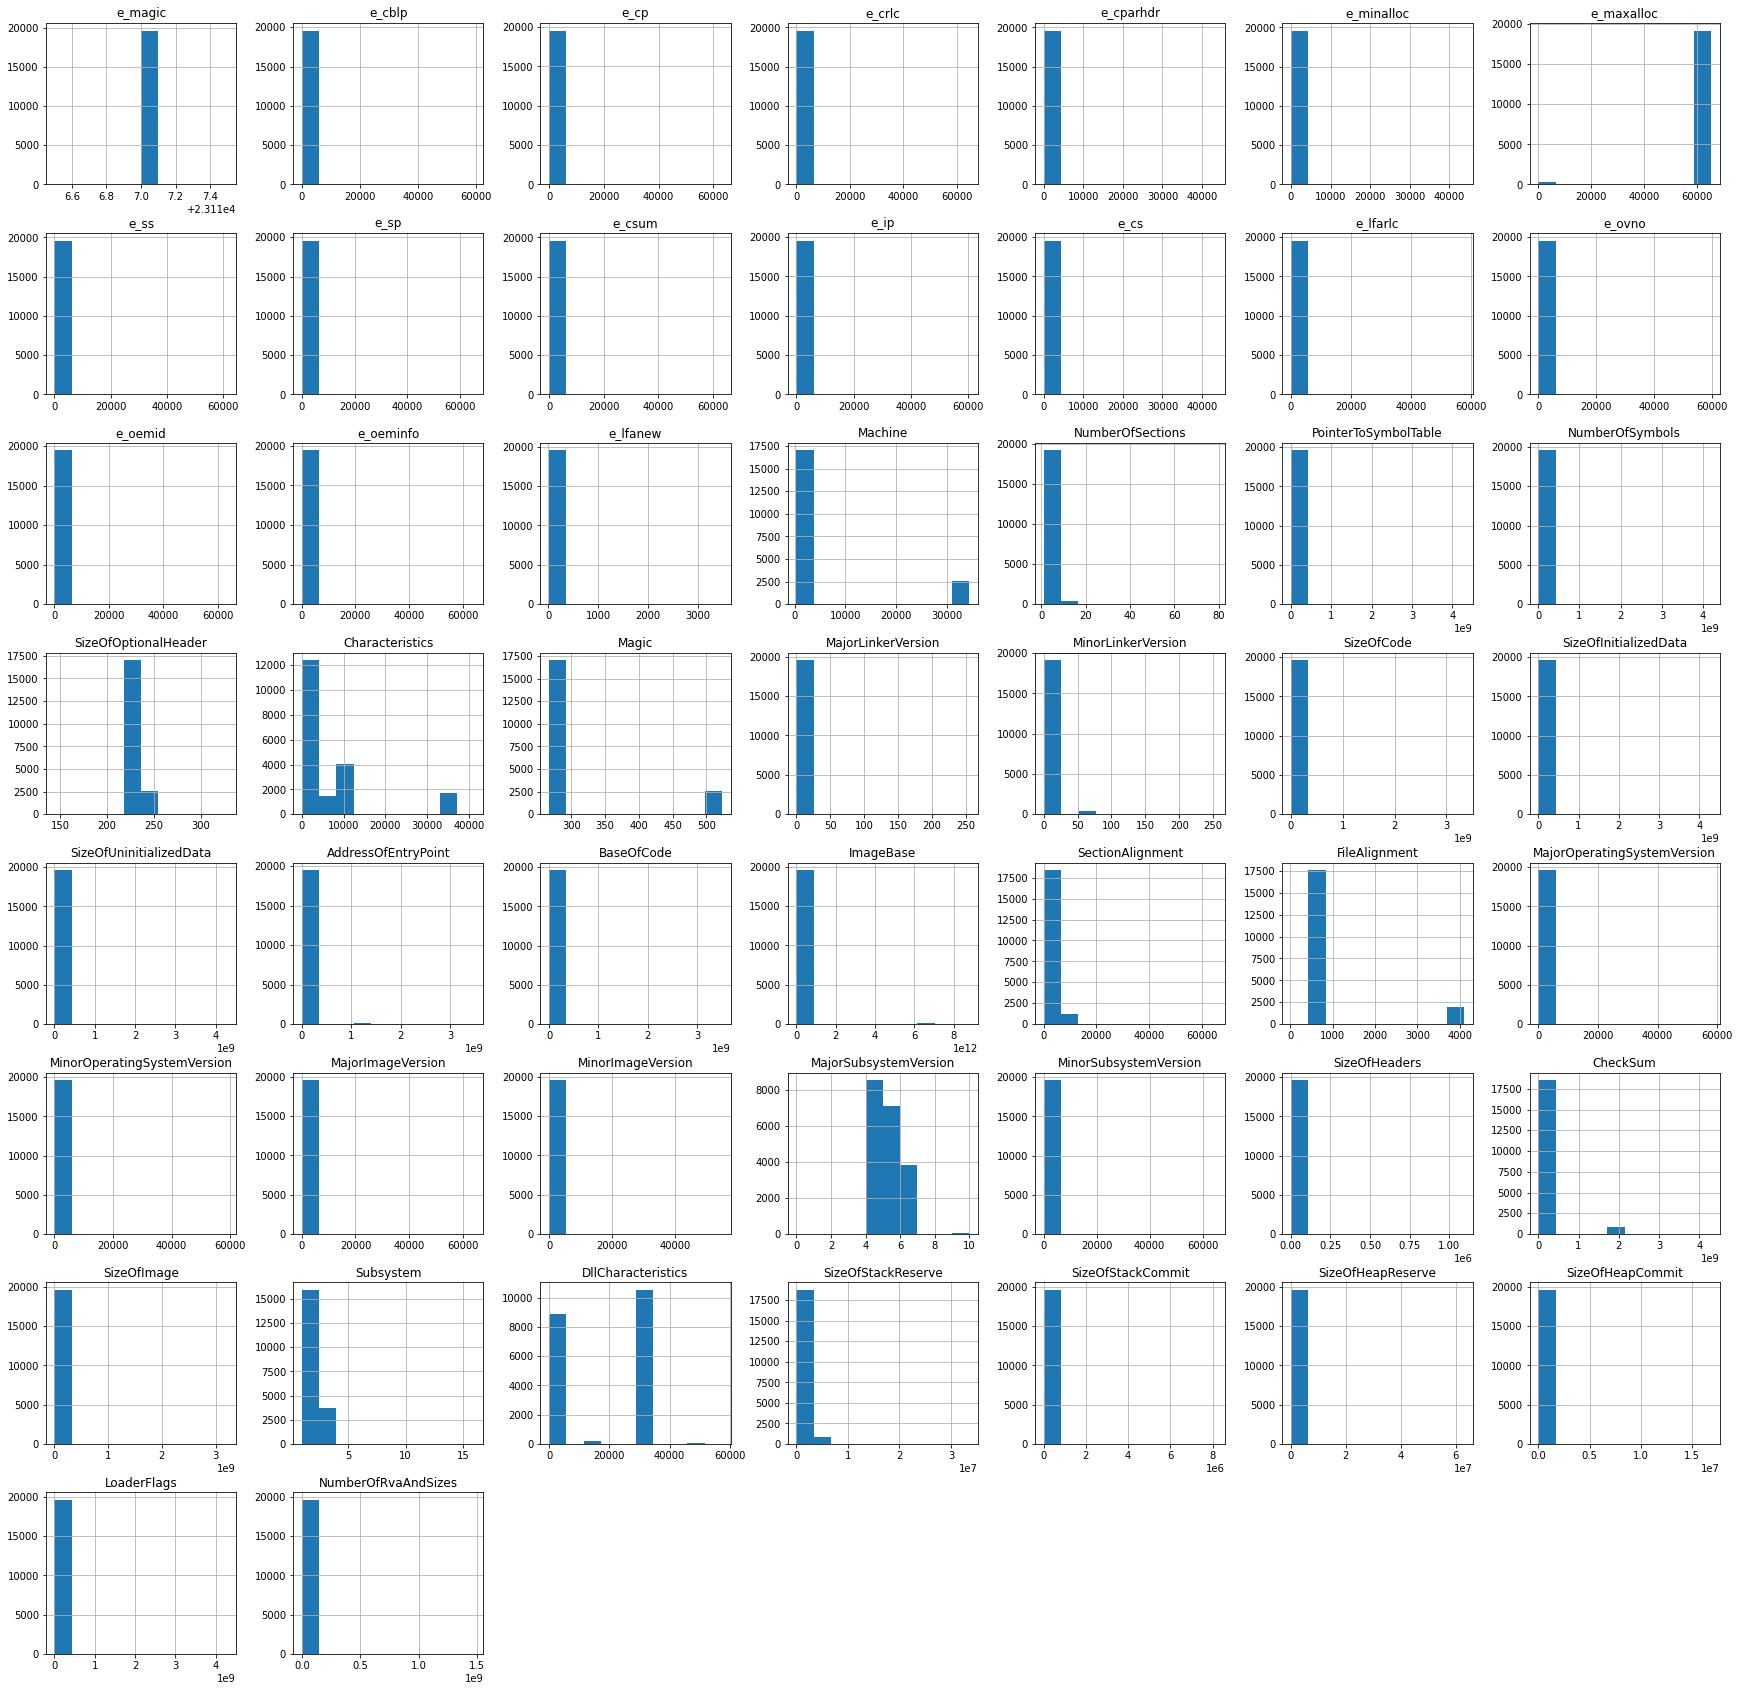

In [ ]:
X.hist(figsize=(30,30))
plt.show()

In [ ]:
# scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler();
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


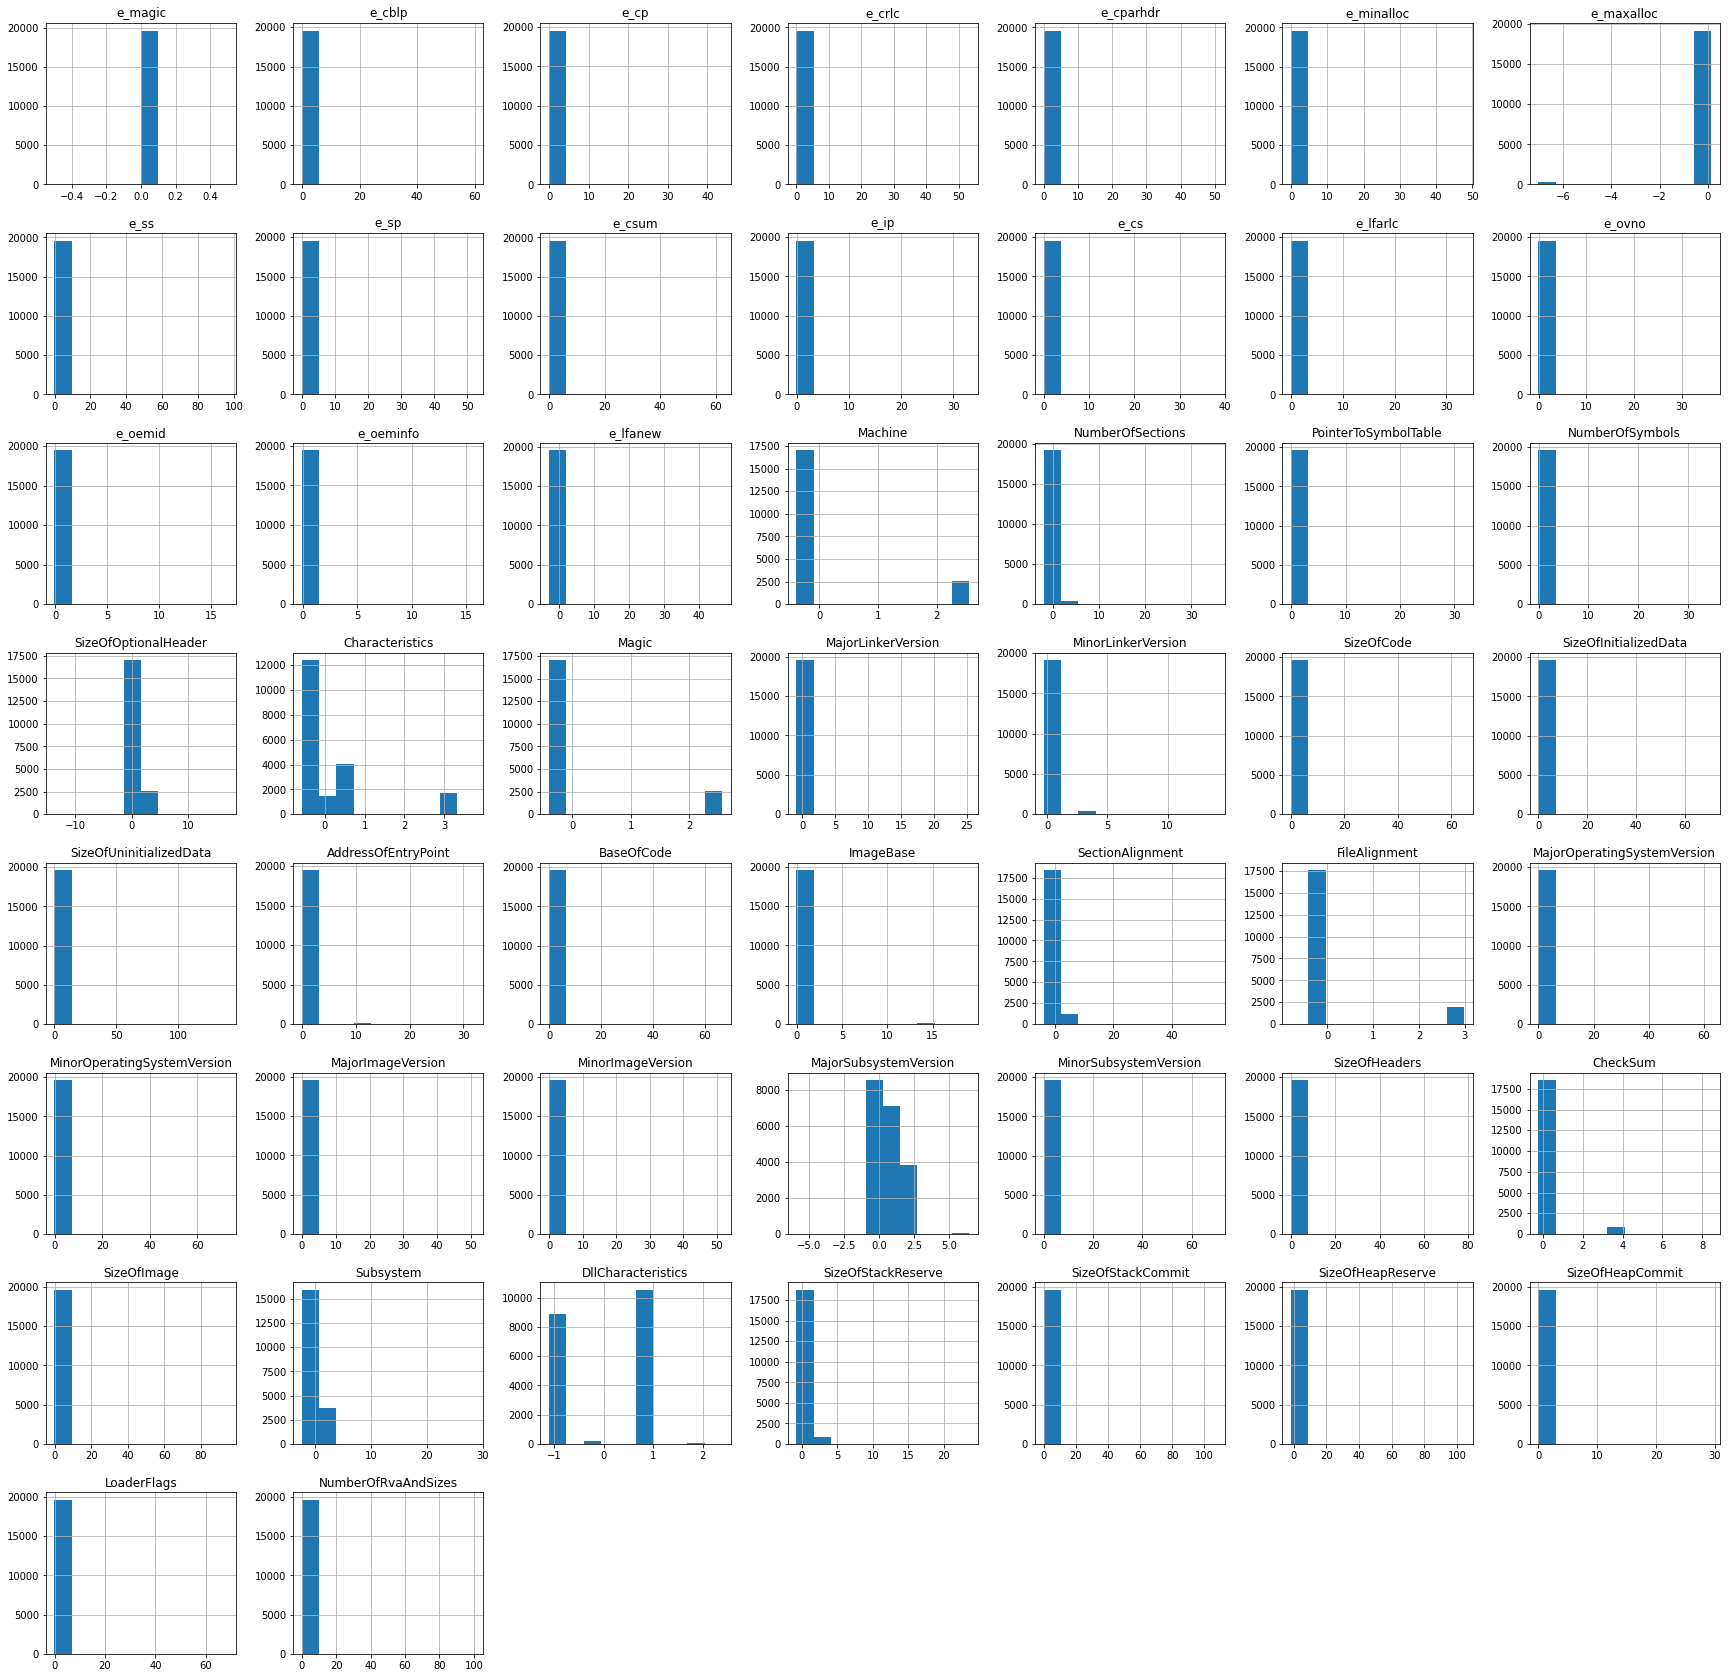

In [ ]:
X_standardized.hist(figsize=(30,30))
plt.show()

# training del modello

In [ ]:
# per risultati riproducibili
import random
import os

os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_standardized, y, test_size=0.33, random_state=42
    )

In [ ]:
print("Malware: {}".format(len(y_train == 1)))
print("Non malware: {}".format(len(y_train == 0)))

Malware: 13140
Non malware: 13140


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [ ]:
# From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# on 10th May 2020
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()
model.add(Dense(80, input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(240))
model.add(Dropout(0.2))
model.add(Dense(80))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

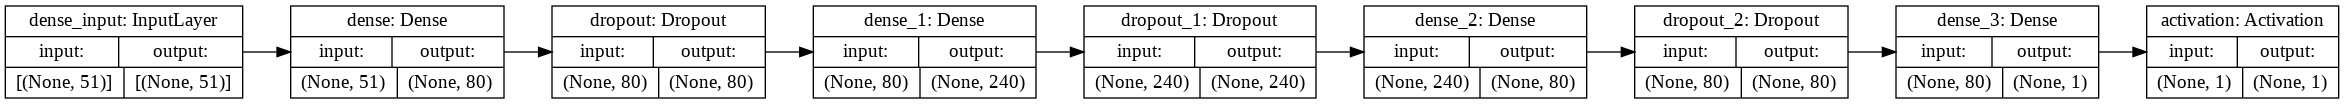

In [ ]:
plot_model(model,
           rankdir="LR",
           expand_nested=True,
           show_shapes=True)

In [ ]:
model.fit(
    X_train, y_train,
    batch_size=64, epochs=10, validation_split=0.05)

Epoch 1/10
196/196 [==============================] - 17s 8ms/step - loss: 0.3428 - acc: 0.8973 - f1_m: 0.9261 - precision_m: 0.9488 - recall_m: 0.9090 - val_loss: 0.1468 - val_acc: 0.9604 - val_f1_m: 0.9741 - val_precision_m: 0.9690 - val_recall_m: 0.9802
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1939 - acc: 0.9458 - f1_m: 0.9635 - precision_m: 0.9583 - recall_m: 0.9694 - val_loss: 0.1441 - val_acc: 0.9619 - val_f1_m: 0.9751 - val_precision_m: 0.9690 - val_recall_m: 0.9821
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1663 - acc: 0.9510 - f1_m: 0.9672 - precision_m: 0.9618 - recall_m: 0.9734 - val_loss: 0.1501 - val_acc: 0.9559 - val_f1_m: 0.9714 - val_precision_m: 0.9672 - val_recall_m: 0.9767
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1624 - acc: 0.9493 - f1_m: 0.9655 - precision_m: 0.9631 - recall_m: 0.9687 - val_loss: 0.1407 - val_acc: 0.9604 - val_f1_m: 0.9741 - val_precision_m: 0.969

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1: %.2f" % f1_score)

Accuracy: 0.96
Precision: 0.97
Recall: 0.97
F1: 0.97


In [ ]:
# previsione sul record aggiunto
model.predict(scaler.transform(rw))

array([[0.79075587]], dtype=float32)

#FSG


In [ ]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification
  """Entry point for launching an IPython kernel.


In [ ]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=X_train.shape[1], loss_object=tf.keras.losses.binary_crossentropy)
attacker = FastGradientMethod(estimator=classifier, minimal=True)

In [ ]:
# record originale
print(np.asarray(rw))

[[  23117     144       3       0       4       0   65535       0     184
        0       0       0      64       0       0       0     128     332
        3       0       0     224      34     267      48       0  137728
     4608       0  145850    8192 4194304    8192     512       4       0
        0       0       4       0     512       0  163840       2   34112
  1048576    4096 1048576    4096       0      16]]


In [ ]:
# genera il nuovo record
ransomware_adv = attacker.generate(scaler.transform(rw))

# stampa le features originali, questo é come deve diventare il PE file
radv = scaler.inverse_transform(ransomware_adv)
print(radv)

[[ 2.31168000e+04 -5.34300845e+01 -2.86023874e+02 -2.42428032e+02
   1.76894271e+02  1.83157296e+02  6.37129407e+04  1.27416757e+02
  -6.59233290e+01  2.03050334e+02 -3.65380582e+02 -2.28524935e+02
  -2.79448785e+02 -3.28942758e+02 -7.63827135e+02 -8.13813237e+02
   1.13960937e+02 -1.97959206e+03  3.41687538e+00 -2.68879251e+07
  -2.41785736e+07  2.25197187e+02  1.93441390e+03  2.84368163e+02
   4.99410137e+01 -3.55231997e+00 -1.01865688e+07 -1.21061468e+07
  -6.13679433e+06 -2.15553067e+07 -1.04922535e+07 -9.20440784e+10
   8.41268562e+03  7.28244005e+02 -1.81178680e+02 -1.62518091e+02
   2.51831380e+02  2.12632673e+02  4.16235880e+00 -1.86437523e+02
  -2.28340176e+03 -9.88610399e+07 -6.63615970e+06  2.09694709e+00
   3.08325052e+04  7.73082795e+05 -1.11033953e+04  9.29948883e+05
  -1.10532758e+05 -1.25183515e+07 -2.94363232e+06]]


In [ ]:
# previsione sul nuovo record

model.predict(ransomware_adv)

array([[0.00763065]], dtype=float32)

In [ ]:
# non ha molto senso che ci siano features negative.
# proviamo a settare i valori negativi a zero e vediamo se misclassifica ancora
# inoltre convertiamo a int (necessario per scrivere poi il PE file)

import math

for i in range(51):
  if radv[0][i] < 0:
    radv[0][i] = 0;

  # usiamo l'arrotondamento con la previsione migliore

  radv[0][i] = math.ceil(radv[0][i])
  #radv[0][i] = math.floor(radv[0][i])
  #radv[0][i] = int(round(radv[0][i]))

print(radv)

[[2.31170e+04 0.00000e+00 0.00000e+00 0.00000e+00 1.77000e+02 1.84000e+02
  6.37130e+04 1.28000e+02 0.00000e+00 2.04000e+02 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.14000e+02 0.00000e+00
  4.00000e+00 0.00000e+00 0.00000e+00 2.26000e+02 1.93500e+03 2.85000e+02
  5.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 8.41300e+03 7.29000e+02 0.00000e+00 0.00000e+00
  2.52000e+02 2.13000e+02 5.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 3.00000e+00 3.08330e+04 7.73083e+05 0.00000e+00 9.29949e+05
  0.00000e+00 0.00000e+00 0.00000e+00]]


In [ ]:
model.predict(scaler.transform(radv))

array([[0.0071111]], dtype=float32)

ora non resta che cambiare il sorgente/PE file per farlo assomigliare a radv

https://docs.microsoft.com/en-us/archive/msdn-magazine/2002/february/inside-windows-win32-portable-executable-file-format-in-detail

https://docs.microsoft.com/en-us/windows/win32/debug/pe-format#overview

In [ ]:
# questi valori non vanno toccati
non_toccare = ['e_magic', 'e_lfanew', 'Machine', 'SizeOfOptionalHeader', 'Characteristics', 'Magic',
'Subsystem', 'DllCharacteristics', 'LoaderFlags', 'NumberOfRvaAndSizes']

# questi valori possono essere cambiati agendo direttamente sul PE file
# l'eseguibile dovrebbe funzionare lo stesso
mod_pe = ['e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc', 'e_maxalloc', 'e_ss', 'e_sp', 
          'e_csum', 'e_ip', 'e_cs', 'e_lfarlc', 'e_ovno', 'e_oemid', 'e_oeminfo', 'MajorImageVersion', 
       'MinorImageVersion', 'MajorLinkerVersion', 'MinorLinkerVersion',
       'CheckSum', 'SizeOfStackCommit', 'SizeOfHeapCommit', 'SizeOfStackReserve', 'SizeOfHeapReserve',
        'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion']

# come sopra ma con alcune limitazioni (es. multiplo di 512)
mod_pe_limitazioni = ['ImageBase', 'SectionAlignment',
       'FileAlignment', 'SizeOfHeaders', 'SizeOfImage']

# questi valori vanno cambiati agendo sul codice
mod_src = ['NumberOfSections', 'PointerToSymbolTable', 'NumberOfSymbols', 'SizeOfCode',
      'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode']


# Versione 1 : Modifica del PE file

In [ ]:
# proviamo a cambiare solo i valori safe, modificando solo il PE file

new = rw.copy()
adv = pd.DataFrame(radv, columns=rw.columns)

for i in mod_pe:
  new[i] = adv[i]

In [ ]:
model.predict(scaler.transform(new))

array([[0.09566805]], dtype=float32)

obiettivo raggiunto, l'eseguibile viene misclassificato.

ora va scritto il nuovo PE file che andrà testato sul sistema

In [ ]:
def modify_pe(pe, adv):
  pe.DOS_HEADER.e_cblp = int(adv['e_cblp'][0])
  pe.DOS_HEADER.e_cp = int(adv['e_cp'][0])
  pe.DOS_HEADER.e_crlc = int(adv['e_crlc'][0])
  pe.DOS_HEADER.e_cparhdr = int(adv['e_cparhdr'][0])
  pe.DOS_HEADER.e_minalloc = int(adv['e_minalloc'][0])
  pe.DOS_HEADER.e_maxalloc = int(adv['e_maxalloc'][0])
  pe.DOS_HEADER.e_ss = int(adv['e_ss'][0])
  pe.DOS_HEADER.e_sp = int(adv['e_sp'][0])
  pe.DOS_HEADER.e_csum = int(adv['e_csum'][0])
  pe.DOS_HEADER.e_ip = int(adv['e_ip'][0])
  pe.DOS_HEADER.e_cs = int(adv['e_cs'][0])
  pe.DOS_HEADER.e_lfarlc = int(adv['e_lfarlc'][0])
  pe.DOS_HEADER.e_ovno = int(adv['e_ovno'][0])
  pe.DOS_HEADER.e_oemid = int(adv['e_oemid'][0])
  pe.DOS_HEADER.e_oeminfo = int(adv['e_oeminfo'][0])

  pe.OPTIONAL_HEADER.MajorImageVersion = int(adv['MajorImageVersion'][0])
  pe.OPTIONAL_HEADER.MinorImageVersion = int(adv['MinorImageVersion'][0])
  pe.OPTIONAL_HEADER.MajorLinkerVersion = int(adv['MajorLinkerVersion'][0])
  pe.OPTIONAL_HEADER.MinorLinkerVersion = int(adv['MinorLinkerVersion'][0])
  pe.OPTIONAL_HEADER.MajorOperatingSystemVersion = int(adv['MajorOperatingSystemVersion'][0])
  pe.OPTIONAL_HEADER.MinorOperatingSystemVersion = int(adv['MinorOperatingSystemVersion'][0])
  pe.OPTIONAL_HEADER.MajorSubsystemVersion = int(adv['MajorSubsystemVersion'][0])
  pe.OPTIONAL_HEADER.MinorSubsystemVersion = int(adv['MinorSubsystemVersion'][0])
  pe.OPTIONAL_HEADER.CheckSum = int(adv['CheckSum'][0])
  pe.OPTIONAL_HEADER.SizeOfStackReserve = int(adv['SizeOfStackReserve'][0])
  pe.OPTIONAL_HEADER.SizeOfStackCommit = int(adv['SizeOfStackCommit'][0])
  pe.OPTIONAL_HEADER.SizeOfHeapReserve = int(adv['SizeOfHeapReserve'][0])
  pe.OPTIONAL_HEADER.SizeOfHeapCommit = int(adv['SizeOfHeapCommit'][0])

  return pe

In [ ]:
pe = modify_pe(pe, adv)
pe.write(filename='modified.exe')

In [ ]:
# verifichiamo che il file sia stato scritto correttamente

pex = pefile.PE('modified.exe')
xx = extract_features(pex)
xxx = [xx]
model.predict(scaler.transform(xxx))

array([[0.09566805]], dtype=float32)

In [ ]:
!zip modified modified.exe

  adding: modified.exe (deflated 76%)


l'eseguibile funziona, cifra e decifra, al momento di chiudersi crasha ma non é un problema.

# Versione 2: Modifica del codice sorgente

proviamo a cambiare solo il codice sorgente.

l'analisi precedente suggerisce di ridurre il più possibile il parametro 'SizeOfCode' e di aumentare 'MajorSubsytemVersion'. La nuova versione del malware cifra solamente i file, non tocca registro o blocca il mouse, non chiede nulla e apre solo una finestra vuota. Viene inoltre compilata con la versione 4.5 di .net framework invece che con la 4.

In [ ]:
!unzip "src_modified.zip"

Archive:  src_modified.zip
  inflating: src_modified.exe        


In [ ]:
spe = pefile.PE('src_modified.exe')
fx = extract_features(spe)
fxx = pd.DataFrame([fx],columns = rw.columns)
model.predict(scaler.transform(fxx))

array([[0.01979449]], dtype=float32)

come speravamo l'eseguibile viene misclassificato. vediamo quali feature sono cambiate rispetto all'originale

In [ ]:
print(np.asarray(rw))
print("------------------------------------------------------------------------")
print(np.asarray(fxx))

[[  23117     144       3       0       4       0   65535       0     184
        0       0       0      64       0       0       0     128     332
        3       0       0     224      34     267      48       0  137728
     4608       0  145850    8192 4194304    8192     512       4       0
        0       0       4       0     512       0  163840       2   34112
  1048576    4096 1048576    4096       0      16]]
------------------------------------------------------------------------
[[  23117     144       3       0       4       0   65535       0     184
        0       0       0      64       0       0       0     128     332
        3       0       0     224      34     267      48       0    6144
     2048       0   14182    8192 4194304    8192     512       4       0
        0       0       6       0     512       0   32768       2   34144
  1048576    4096 1048576    4096       0      16]]


In [ ]:
rw == fx

,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,e_ip,e_cs,e_lfarlc,e_ovno,e_oemid,e_oeminfo,e_lfanew,Machine,NumberOfSections,PointerToSymbolTable,NumberOfSymbols,SizeOfOptionalHeader,Characteristics,Magic,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfHeaders,CheckSum,SizeOfImage,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,False,True,True,True,True,True,True,True,True,False,True,True,True,False,True,False,True,True,True,True,True,True


cosa sarebbe successo se avessimo semplicemente ricompilato con .net 4.5?

In [ ]:
!unzip "malware_45.zip"

Archive:  malware_45.zip
  inflating: malware_45.exe          


In [ ]:
spe45 = pefile.PE('malware_45.exe')
fx45 = extract_features(spe45)
fxx45 = pd.DataFrame([fx45],columns = rw.columns)
model.predict(scaler.transform(fxx45))

array([[0.0199284]], dtype=float32)

In [ ]:
print(np.asarray(fxx))
print("------------------------------------------------------------------------")
print(np.asarray(fxx45))

[[  23117     144       3       0       4       0   65535       0     184
        0       0       0      64       0       0       0     128     332
        3       0       0     224      34     267      48       0    6144
     2048       0   14182    8192 4194304    8192     512       4       0
        0       0       6       0     512       0   32768       2   34144
  1048576    4096 1048576    4096       0      16]]
------------------------------------------------------------------------
[[  23117     144       3       0       4       0   65535       0     184
        0       0       0      64       0       0       0     128     332
        3       0       0     224      34     267      48       0  137728
     4608       0  145854    8192 4194304    8192     512       4       0
        0       0       6       0     512       0  163840       2   34144
  1048576    4096 1048576    4096       0      16]]


ricompilare sarebbe stato sufficiente, la riduzione di codice non ha influito molto. Questo ci porta a concludere che la rete fa molto affidamento su features che non sono strettamente legate al comportamento benevolo/malevolo dell'eseguibile.

# Modifica del Modello

visto che le features in mod_pe possono essere cambiate facilmente dall'attaccante, tanto vale toglierle

In [ ]:
X = data.drop(["Name","Malware","TimeDateStamp"], axis=1)

# teniamo le prime 51
X = X[X.columns[:51]]

# togliamo le features modificabili
X2 = X.drop(mod_pe, axis=1)
rw2 = rw.drop(mod_pe, axis=1) # originale

# aggiungiamo il nuovo record al dataset
X2 = X2.append(rw2)
y2 = pd.DataFrame(data['Malware'])
y2 = y2.append(rwy)

print(X2.shape)
print(y2.shape)

(19612, 23)
(19612, 1)


In [ ]:
# scaling

from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler();
X_standardized = pd.DataFrame(scaler2.fit_transform(X2), columns=X2.columns)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_standardized, y, test_size=0.33, random_state=42
    )

In [ ]:
model2 = Sequential()
model2.add(Dense(80, input_dim=X_train.shape[1]))
model2.add(Dropout(0.2))
model2.add(Dense(240))
model2.add(Dropout(0.2))
model2.add(Dense(80))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.add(Activation('sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
model2.fit(
    X_train, y_train,
    batch_size=64, epochs=10, validation_split=0.05)

Epoch 1/10
196/196 [==============================] - 3s 7ms/step - loss: 0.4452 - acc: 0.8215 - f1_m: 0.8756 - precision_m: 0.8791 - recall_m: 0.8808 - val_loss: 0.3295 - val_acc: 0.8828 - val_f1_m: 0.9277 - val_precision_m: 0.8960 - val_recall_m: 0.9625
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 0.3744 - acc: 0.8636 - f1_m: 0.9120 - precision_m: 0.8736 - recall_m: 0.9556 - val_loss: 0.3274 - val_acc: 0.8737 - val_f1_m: 0.9233 - val_precision_m: 0.8847 - val_recall_m: 0.9666
Epoch 3/10
196/196 [==============================] - 1s 4ms/step - loss: 0.3561 - acc: 0.8691 - f1_m: 0.9154 - precision_m: 0.8803 - recall_m: 0.9553 - val_loss: 0.3269 - val_acc: 0.8935 - val_f1_m: 0.9304 - val_precision_m: 0.9134 - val_recall_m: 0.9494
Epoch 4/10
196/196 [==============================] - 1s 4ms/step - loss: 0.3664 - acc: 0.8656 - f1_m: 0.9126 - precision_m: 0.8762 - recall_m: 0.9543 - val_loss: 0.3197 - val_acc: 0.8798 - val_f1_m: 0.9266 - val_precision_m: 0.8890

In [ ]:
loss, accuracy, f1_score, precision, recall = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1: %.2f" % f1_score)

Accuracy: 0.88
Precision: 0.89
Recall: 0.96
F1: 0.92


In [ ]:
# previsione sull'eseguibile originale
model2.predict(scaler2.transform(rw2))

array([[0.6493603]], dtype=float32)

In [ ]:
# previsione sull'eseguibile con sorgente modificato
rws = fxx.drop(mod_pe, axis=1)

model2.predict(scaler2.transform(rws))

array([[0.6476778]], dtype=float32)

In [ ]:
# previsione sull'eseguibile ricompilato
rws45 = fxx45.drop(mod_pe, axis=1)

model2.predict(scaler2.transform(rws45))

array([[0.6497037]], dtype=float32)

avendo rimosso le features inutili, la rete ora riconosce come malware sia l'eseguibile ricompilato che quello con codice sorgente modificato.